In [392]:
#Trazendo os dados de vendas
import pandas as pd

sales = pd.read_csv('bases/data_base.csv')
print(sales)

            date                 datetime  ...  money    coffee_name
0     2024-03-01  2024-03-01 10:15:50.520  ...  38.70          Latte
1     2024-03-01  2024-03-01 12:19:22.539  ...  38.70  Hot Chocolate
2     2024-03-01  2024-03-01 12:20:18.089  ...  38.70  Hot Chocolate
3     2024-03-01  2024-03-01 13:46:33.006  ...  28.90      Americano
4     2024-03-01  2024-03-01 13:48:14.626  ...  38.70          Latte
...          ...                      ...  ...    ...            ...
3631  2025-03-23  2025-03-23 10:34:54.894  ...  35.76     Cappuccino
3632  2025-03-23  2025-03-23 14:43:37.362  ...  35.76          Cocoa
3633  2025-03-23  2025-03-23 14:44:16.864  ...  35.76          Cocoa
3634  2025-03-23  2025-03-23 15:47:28.723  ...  25.96      Americano
3635  2025-03-23  2025-03-23 18:11:38.635  ...  35.76          Latte

[3636 rows x 6 columns]


In [393]:
#Filtrando os dados
import warnings
warnings.filterwarnings("ignore")

sales = sales[["date", "coffee_name"]]
sales["date"] = pd.to_datetime(sales["date"])
sales = sales.groupby(sales["date"].dt.to_period('m'))["coffee_name"].count().reset_index(name="qtd")
sales["date"] = sales["date"].dt.to_timestamp()
sales.set_index("date", inplace=True)

display(sales)

,qtd
date,
2024-03-01,206
2024-04-01,196
2024-05-01,267
2024-06-01,227
2024-07-01,237
2024-08-01,272
2024-09-01,344
2024-10-01,426
2024-11-01,259


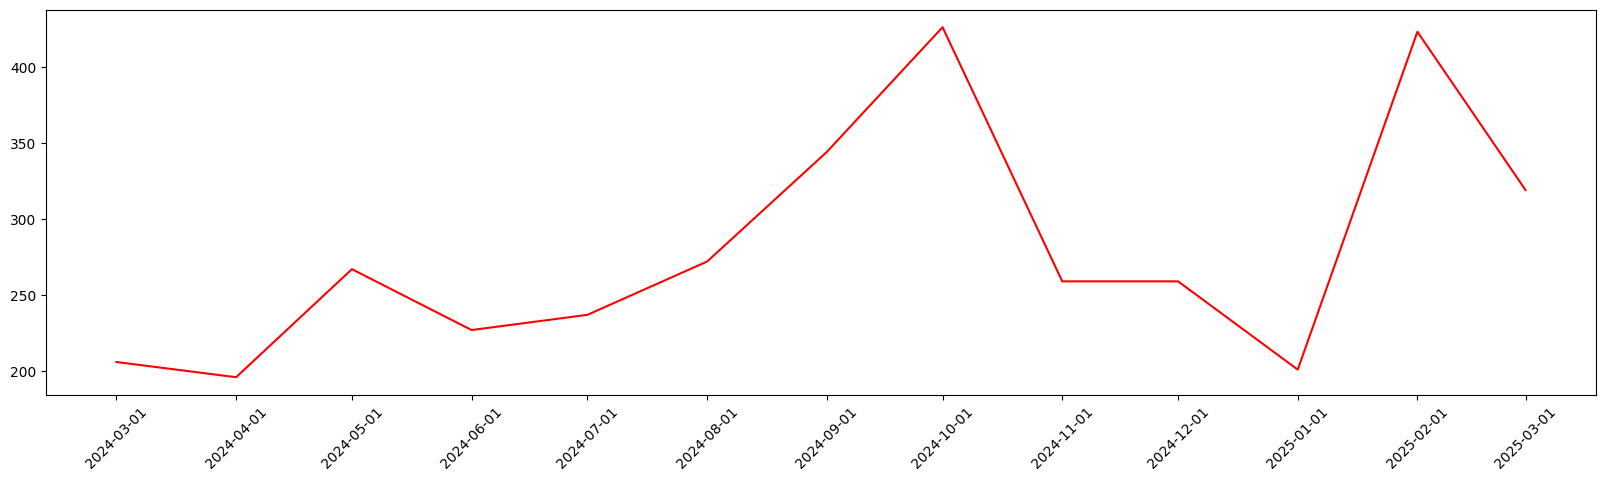

In [394]:
#Plotando dados
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(sales.index, sales.values, color='r', label="Sales")
plt.xticks(sales.index, rotation=45)
plt.show()


In [395]:
#testando estacionaridade
from statsmodels.tsa.stattools import adfuller

test_result = adfuller(sales["qtd"])
print(test_result)

print(f'ADF Statistic: {test_result[0]}')
print(f'p-value: {test_result[1]}')


(np.float64(-1.3457972589972371), np.float64(0.6079684697577467), 3, 9, {'1%': np.float64(-4.473135048010974), '5%': np.float64(-3.28988060356653), '10%': np.float64(-2.7723823456790124)}, np.float64(90.5024702993993))
ADF Statistic: -1.3457972589972371
p-value: 0.6079684697577467


date
2024-05-01     81.0
2024-06-01   -111.0
2024-07-01     50.0
2024-08-01     25.0
2024-09-01     37.0
2024-10-01     10.0
2024-11-01   -249.0
2024-12-01    167.0
2025-01-01    -58.0
2025-02-01    280.0
2025-03-01   -326.0
Name: qtd, dtype: float64


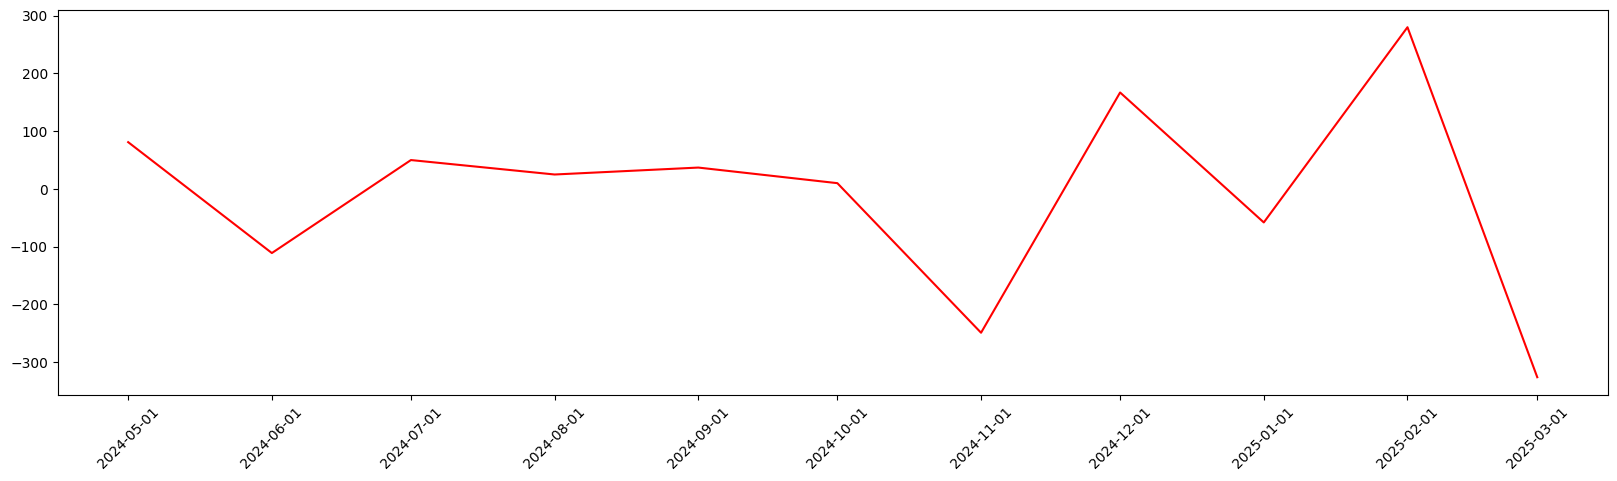

(np.float64(-4.799698333339278), np.float64(5.445824817243137e-05), 3, 7, {'1%': np.float64(-4.9386902332361515), '5%': np.float64(-3.477582857142857), '10%': np.float64(-2.8438679591836733)}, np.float64(81.46451182025864))


In [396]:
#diferenciando e testando
test_diff = sales['qtd'].diff().diff().dropna()

print(test_diff)
plt.figure(figsize=(20,5))
plt.plot(test_diff.index, test_diff.values, color='r', label="Sales")
plt.xticks(test_diff.index, rotation=45)
plt.show()
test_result_diff = adfuller(test_diff)

print(test_result_diff)

In [397]:
#Definindo modelo ARIMA
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sales, order=(1,2,2), seasonal_order=(1, 2, 2, 12))
model_fit = model.fit()
print(model_fit.summary())



                                    SARIMAX Results                                     
Dep. Variable:                              qtd   No. Observations:                   13
Model:             ARIMA(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood                   0.000
Date:                          Thu, 02 Oct 2025   AIC                             14.000
Time:                                  21:09:41   BIC                                nan
Sample:                              03-01-2024   HQIC                               nan
                                   - 03-01-2025                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        

              lower qtd    upper qtd
2024-08-01 -2524.808342  3018.808342
2024-09-01 -2464.808342  3078.808342
2024-10-01 -2355.808342  3187.808342
2024-11-01 -2263.808342  3279.808342
2024-12-01 -2679.808342  2863.808342
2025-01-01 -2512.808342  3030.808342
2025-02-01 -2628.808342  2914.808342
2025-03-01 -2372.385852  3881.658698

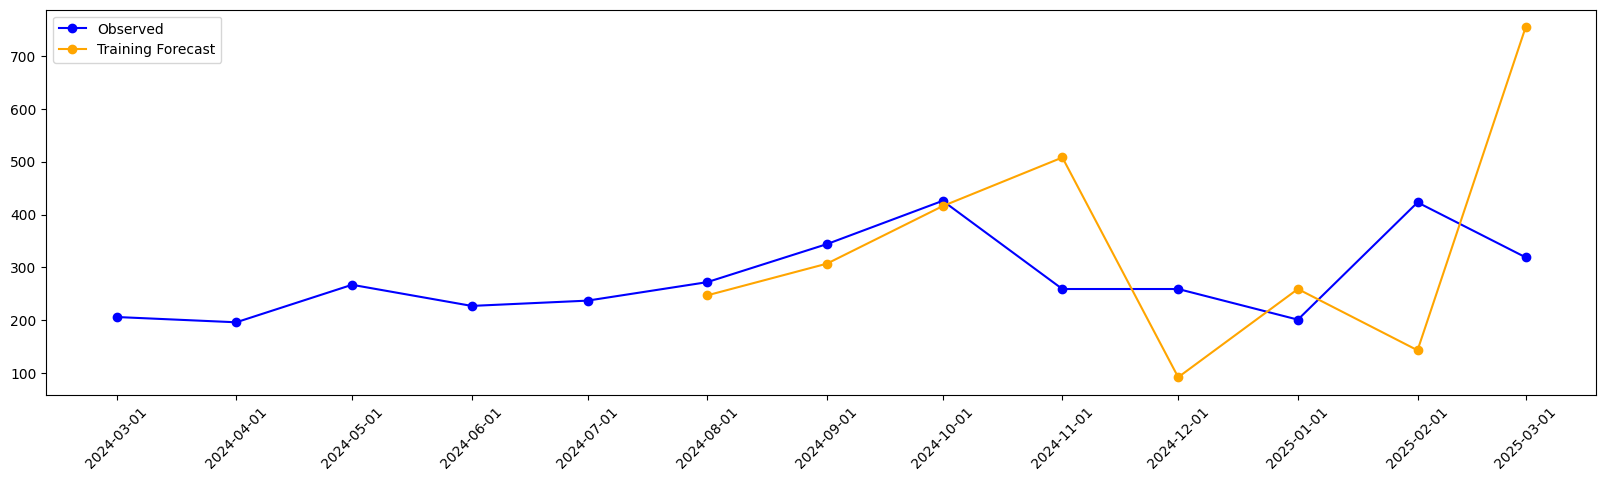

In [398]:
#Treinando Modelo e plotando

training = model_fit.get_prediction(start=-8, dynamic=False)
mean_training = training.predicted_mean
confiance_intervals = training.conf_int()
print(confiance_intervals)

plt.figure(figsize=(20, 5))
plt.plot(sales.index, sales.values, color='blue', marker='o', label='Observed')
plt.plot(mean_training.index, mean_training.values, color='orange', marker='o', label='Training Forecast')
# plt.fill_between(confiance_intervals.index, confiance_intervals.iloc[:,0], confiance_intervals.iloc[:,1], color='pink')
plt.xticks(sales.index, rotation=45)
plt.legend()
plt.show()


2025-04-01    175.571345
2025-05-01    153.642710
2025-06-01    -34.785952
2025-07-01   -148.214602
2025-08-01   -224.143246
2025-09-01   -244.571880
Freq: MS, Name: predicted_mean, dtype: float64


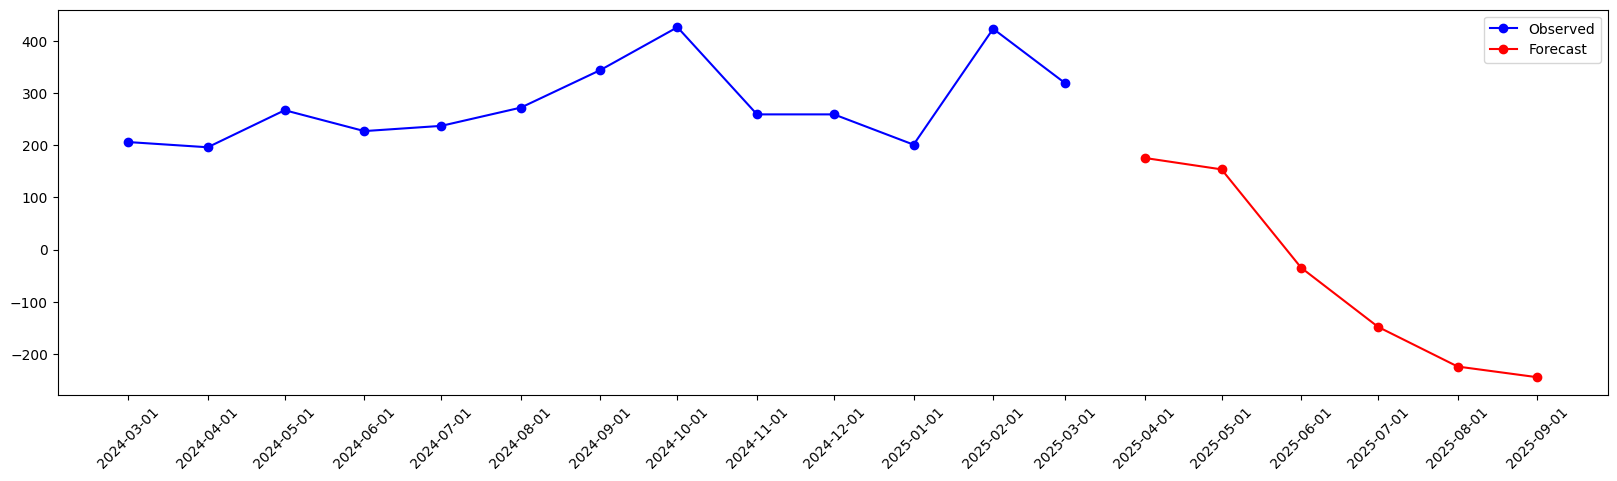

In [399]:
#Fazendo previsões com o modelo
import numpy as np

forecast = model_fit.get_forecast(steps=6).predicted_mean
print(forecast)

plt.figure(figsize=(20,5))
plt.plot(sales.index, sales.values, color='blue', marker='o', label='Observed')
plt.plot(forecast.index, forecast.values, color='red', marker='o', label='Forecast')
all_xticks = np.unique(np.concatenate([sales.index, forecast.index]))
plt.xticks(all_xticks, rotation=45)
plt.legend()
plt.show()